In [1]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D,ZeroPadding2D, Flatten, Input, Lambda, BatchNormalization
from tensorflow.keras import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop as rms
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import cedar
import os

In [5]:
def base_model(inputs=(155,220,1)):
    input_ = Input(inputs)
    x = Conv2D(96, (11,11), strides=(1,1), padding='same', activation='relu')(input_)
    x = BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)(x)
    x = MaxPooling2D(pool_size=(3,3) , strides=(2,2))(x)
    x = ZeroPadding2D((2, 2))(x)
    x = Conv2D(256 , (5,5) , padding='same' , activation='relu')(x)
    x = BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
    x = Dropout(0.3)(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(384 , (3,3) , padding='same', activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256 , (3,3) , padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2))(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(1024 ,kernel_regularizer=l2(0.0005), activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(128 ,kernel_regularizer=l2(0.0005), activation='relu')(x)
    return Model(inputs=input_ , outputs=output)

def eucledian_distance(vectors):
    vect1 , vect2 = vectors
    sum_sq = K.sum(K.square(vect1 - vect2) , axis=1 , keepdims=True)
    dist = K.sqrt(K.maximum(sum_sq , K.epsilon()))
    return dist

def eucledian_distance_output_shape(shapes):
    shape1 , _ = shapes
    return (shape1[0] , 1)

def contrastive_loss_with_margin(margin): 
    def contrastive_loss(y_true, y_pred): 
        square_pred = K.square(y_pred) 
        margin_square = K.square(K.maximum(margin - y_pred, 0)) 
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square) 
    return contrastive_loss 

def plot_metrics(metric , title , ylim=5):
    plt.title(title)
    plt.ylim(0 , ylim)
    plt.plot(history.history[metric] , color='green' , label=metric)

def predict_plot(img1 , img2 , title1 , title2):
  img1 = np.expand_dims(cedar.preprocessing(img1) , axis=0)
  img2 = np.expand_dims(cedar.preprocessing(img2) , axis=0)
  pred = new.predict([img1 , img2])[0][0]
  img1 = np.reshape(img1 , (155,220))
  img2 = np.reshape(img2 , (155,220))
  fig = plt.figure(figsize=(8, 8))
  fig.add_subplot(1, 2, 1)
  plt.imshow(img1)
  plt.title(title1)
  fig.add_subplot(1, 2, 2)
  plt.imshow(img2)
  plt.title(title2)
  plt.show()
  if pred > 0.5:
    print('It is a forged signature')
  else: print('It is not a forged signature')

In [ ]:

base = base_model()

In [ ]:
base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 155, 220, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 155, 220, 96)      11712     
                                                                 
 batch_normalization (BatchN  (None, 155, 220, 96)     620       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 77, 109, 96)      0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 81, 113, 96)      0         
 2D)                                                             
                                                             

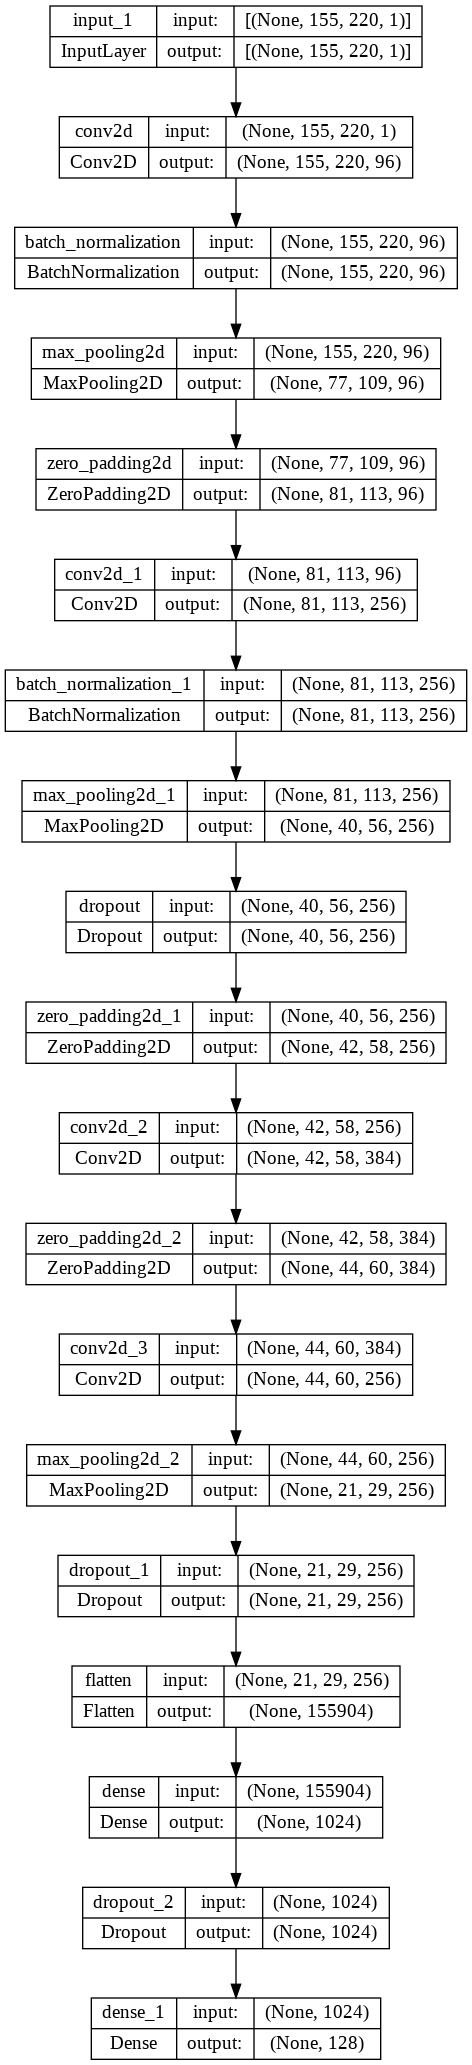

In [ ]:
plot_model(base, 
    to_file="base_sig_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [ ]:
def siamese_model(inputs , output):
    input1 , input2 = inputs
    vector_1 = base(input1)
    vector_2 = base(input2)
    lmbda = output([vector_1 , vector_2])
    return Model(inputs= [input1 , input2], outputs=lmbda)

In [ ]:
input1 = Input((155 , 220 , 1))
input2 = Input((155 , 220 , 1))
output = Lambda(eucledian_distance , output_shape=eucledian_distance_output_shape)

In [ ]:
signet = siamese_model([input1 , input2] , output)

In [ ]:
signet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128)          162175344   ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [3]:
cedar.load_data()

100% [......................................................................] 253587033 / 253587033patool: Extracting signatures.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- "C:\Users\parij\Machine Learning\siamese_networks\signatures.rar"
patool:     with cwd=.\Unpack_stqzoulm
patool: ... signatures.rar extracted to `signatures'.


In [ ]:
(X_train , Y_train) , (X_test , Y_test) = cedar.create_dataset(os.path.join('signatures' , 'full_org') , os.path.join('signatures' , 'full_forg') )

In [ ]:
signet.compile(loss=contrastive_loss_with_margin(margin=1) , optimizer=rms(learning_rate=1e-4, rho=0.9, epsilon=1e-08))

In [ ]:
history = signet.fit([X_train[0] , X_train[1]] , Y_train , epochs=20, batch_size=128)

In [ ]:
signet.save(signet)

In [ ]:
new = load_model('signet' , custom_objects={'contrastive_loss':contrastive_loss_with_margin})

1/1 [==============================] - 0s 22ms/step


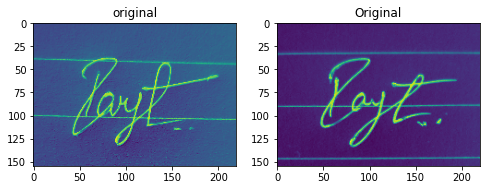

It is not a forged signature


In [81]:
predict_plot(os.path.join('sample_imgs' , 'org.jpg') , os.path.join('sample_imgs' , 'org2.jpg') , 'original' , 'Original')

1/1 [==============================] - 0s 22ms/step


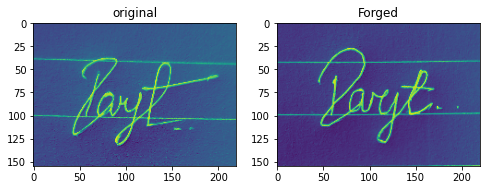

It is a forged signature


In [84]:
predict_plot(os.path.join('sample_imgs' , 'org.jpg') , os.path.join('sample_imgs' , 'forg.jpg') , 'original' , 'Forged')